In [ ]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import anndata as ad
from scipy.spatial.distance import cdist
from tqdm.notebook import tqdm
import os
from sklearn.neighbors import NearestNeighbors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.decomposition import NMF

from fbpca import pca
import time
from geosketch import gs

import glob

from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from tqdm import tqdm


In [ ]:
path = '/storage/adult_brain_genes/sketches_gene_choice_scripts'

In [ ]:
adata = sc.read(os.path.join(path, 'combined_sketches.h5ad'))

# Create Temporary Dataset Sketch for Faster Runtime

In [ ]:
sc.pp.highly_variable_genes(adata)
#adata = adata[:,persist['0'].tolist()]

X_matrix = np.array(adata[:,adata.var.highly_variable].X.todense())

N = 10000
U, s, Vt = pca(X_matrix[:,:], k=100) # E.g., 100 PCs.
X_dimred = U[:, :100] * s[:100]


time1 = time.time()

sketch_index = gs(X_dimred, N, replace=False)

X_sketch = X_dimred[sketch_index]
print(time.time()- time1)

adata_sketch = adata[sketch_index, adata.var.highly_variable]


# Recursive Feature Elimination

In [ ]:
selected_genes_list_2 = []
num_genes = []
num_genes_to_remove = 200
clusters_ari, clusters_ami = [], []

num_features = len(adata_sketch.var.index.tolist())
num_genes_remaining = num_features

while num_genes_remaining > 0:
    X = adata_sketch.X
    y = np.array(adata_sketch.obs['celltype'].tolist())

    # Define the random forest classifier
    clf = RandomForestClassifier(n_estimators=100, random_state=42)

    # Calculate the number of genes to select in this iteration
    if num_genes_remaining <= num_genes_to_remove:
        num_genes_to_select = num_genes_remaining - 1  # Keep 1 gene at the end
    else:
        num_genes_to_select = num_genes_remaining - num_genes_to_remove

    # Define the RFE selector with a step size of 5 genes
    selector = RFE(clf, n_features_to_select=num_genes_to_select, step=np.max([1, num_genes_to_remove//2]))

    print('Fitting RFE with num_genes_to_select:', num_genes_to_select)

    # Fit the selector to your data to identify the top genes
    selector.fit(X, y)

    # Extract the selected gene names
    selected_genes = selector.support_
    adata_sketch = adata_sketch[:, selected_genes]
    selected_genes_list_2.append(adata_sketch.var.index.tolist())
    num_genes.append(len(adata_sketch.var.index))

    num_genes_remaining = len(adata_sketch.var.index)

    # Decrease the number of genes to remove in the next iteration
    num_genes_to_remove = max(1, int(num_genes_to_remove * 0.967))  # Decrease by 2% each iteration

In [ ]:
import pickle

# List to be serialized
my_list = selected_genes_list_2

# File path to save the pickle file
file_path = os.path.join(path, "whole_transcriptome_selected_genes_subclass.pkl")
# Serialize and save the list to a pickle file
with open(file_path, 'wb') as f:
    pickle.dump(my_list, f)

print(f"List has been saved to {file_path} as a pickle file.")


In [ ]:
import pickle
with open(os.path.join(path, "whole_transcriptome_selected_genes_subclass.pkl", 'rb')) as f:
    new_data = pickle.load(f)
selected_genes_list = new_data.copy()

### Calculate Accuracies at Each Level of Gene Elimination

In [ ]:
sc.set_figure_params(dpi=300)
gene_list_size = 350
aris = []
amis = []
total_list_sizes = []

for k in tqdm(range(len(selected_genes_list))):
    total_list_sizes.append(selected_genes_list[k])
    subset_adata = adata[:,adata.var.index.isin(selected_genes_list[k])]

    sc.tl.pca(subset_adata)
    
    from sklearn.metrics import adjusted_rand_score
    import scanpy as sc
    import numpy as np


    import statistics as stats
    sc.pp.neighbors(subset_adata, n_neighbors=6, knn=True, key_added='knn5_real')

    ncells=[]
    for i in range(len(subset_adata.obs.index)):
        neighbor_index = list(np.ascontiguousarray(subset_adata.obsp['knn5_real_distances'][i].nonzero())[1])
        try:
            newcell = stats.mode([subset_adata.obs['Subclusters'][n] for n in neighbor_index])
        except:
            newcell = ''
        ncells.append(newcell)
    subset_adata.obs['new_cluster'] = ncells

    # Get the predicted and actual observation columns
    predicted = subset_adata.obs['new_cluster']
    obs = subset_adata.obs['Subclusters']

    # Compute the ARI between the columns
    ari = adjusted_rand_score(obs, predicted)

    print(f"The ARI between the 'obs' and 'predicted' columns is {ari:.3f}")
    aris.append(ari)
    from sklearn.metrics.cluster import adjusted_mutual_info_score

    # calculate AMI
    ami_score = adjusted_mutual_info_score(obs, predicted)

    print(f"AMI score: {ami_score:.4f}")
    amis.append(ami_score)


### Format outputs

In [ ]:
tees = []
for t in predicted.values:
    if t == '':
        tees.append(-1)
    else:
        tees.append(t)

In [ ]:
# Compute the ARI between the columns
ari = adjusted_rand_score(obs, tees)

print(f"The ARI between the 'obs' and 'predicted' columns is {ari:.3f}")
aris.append(ari)
from sklearn.metrics.cluster import adjusted_mutual_info_score

# calculate AMI
ami_score = adjusted_mutual_info_score(obs, tees)

print(f"AMI score: {ami_score:.4f}")
amis.append(ami_score)

In [ ]:
total_list_sizes = [len(k) for k in total_list_sizes]

In [ ]:
total_list_sizes.append(0)
aris.append(0)
amis.append(0)

### Plot outputs

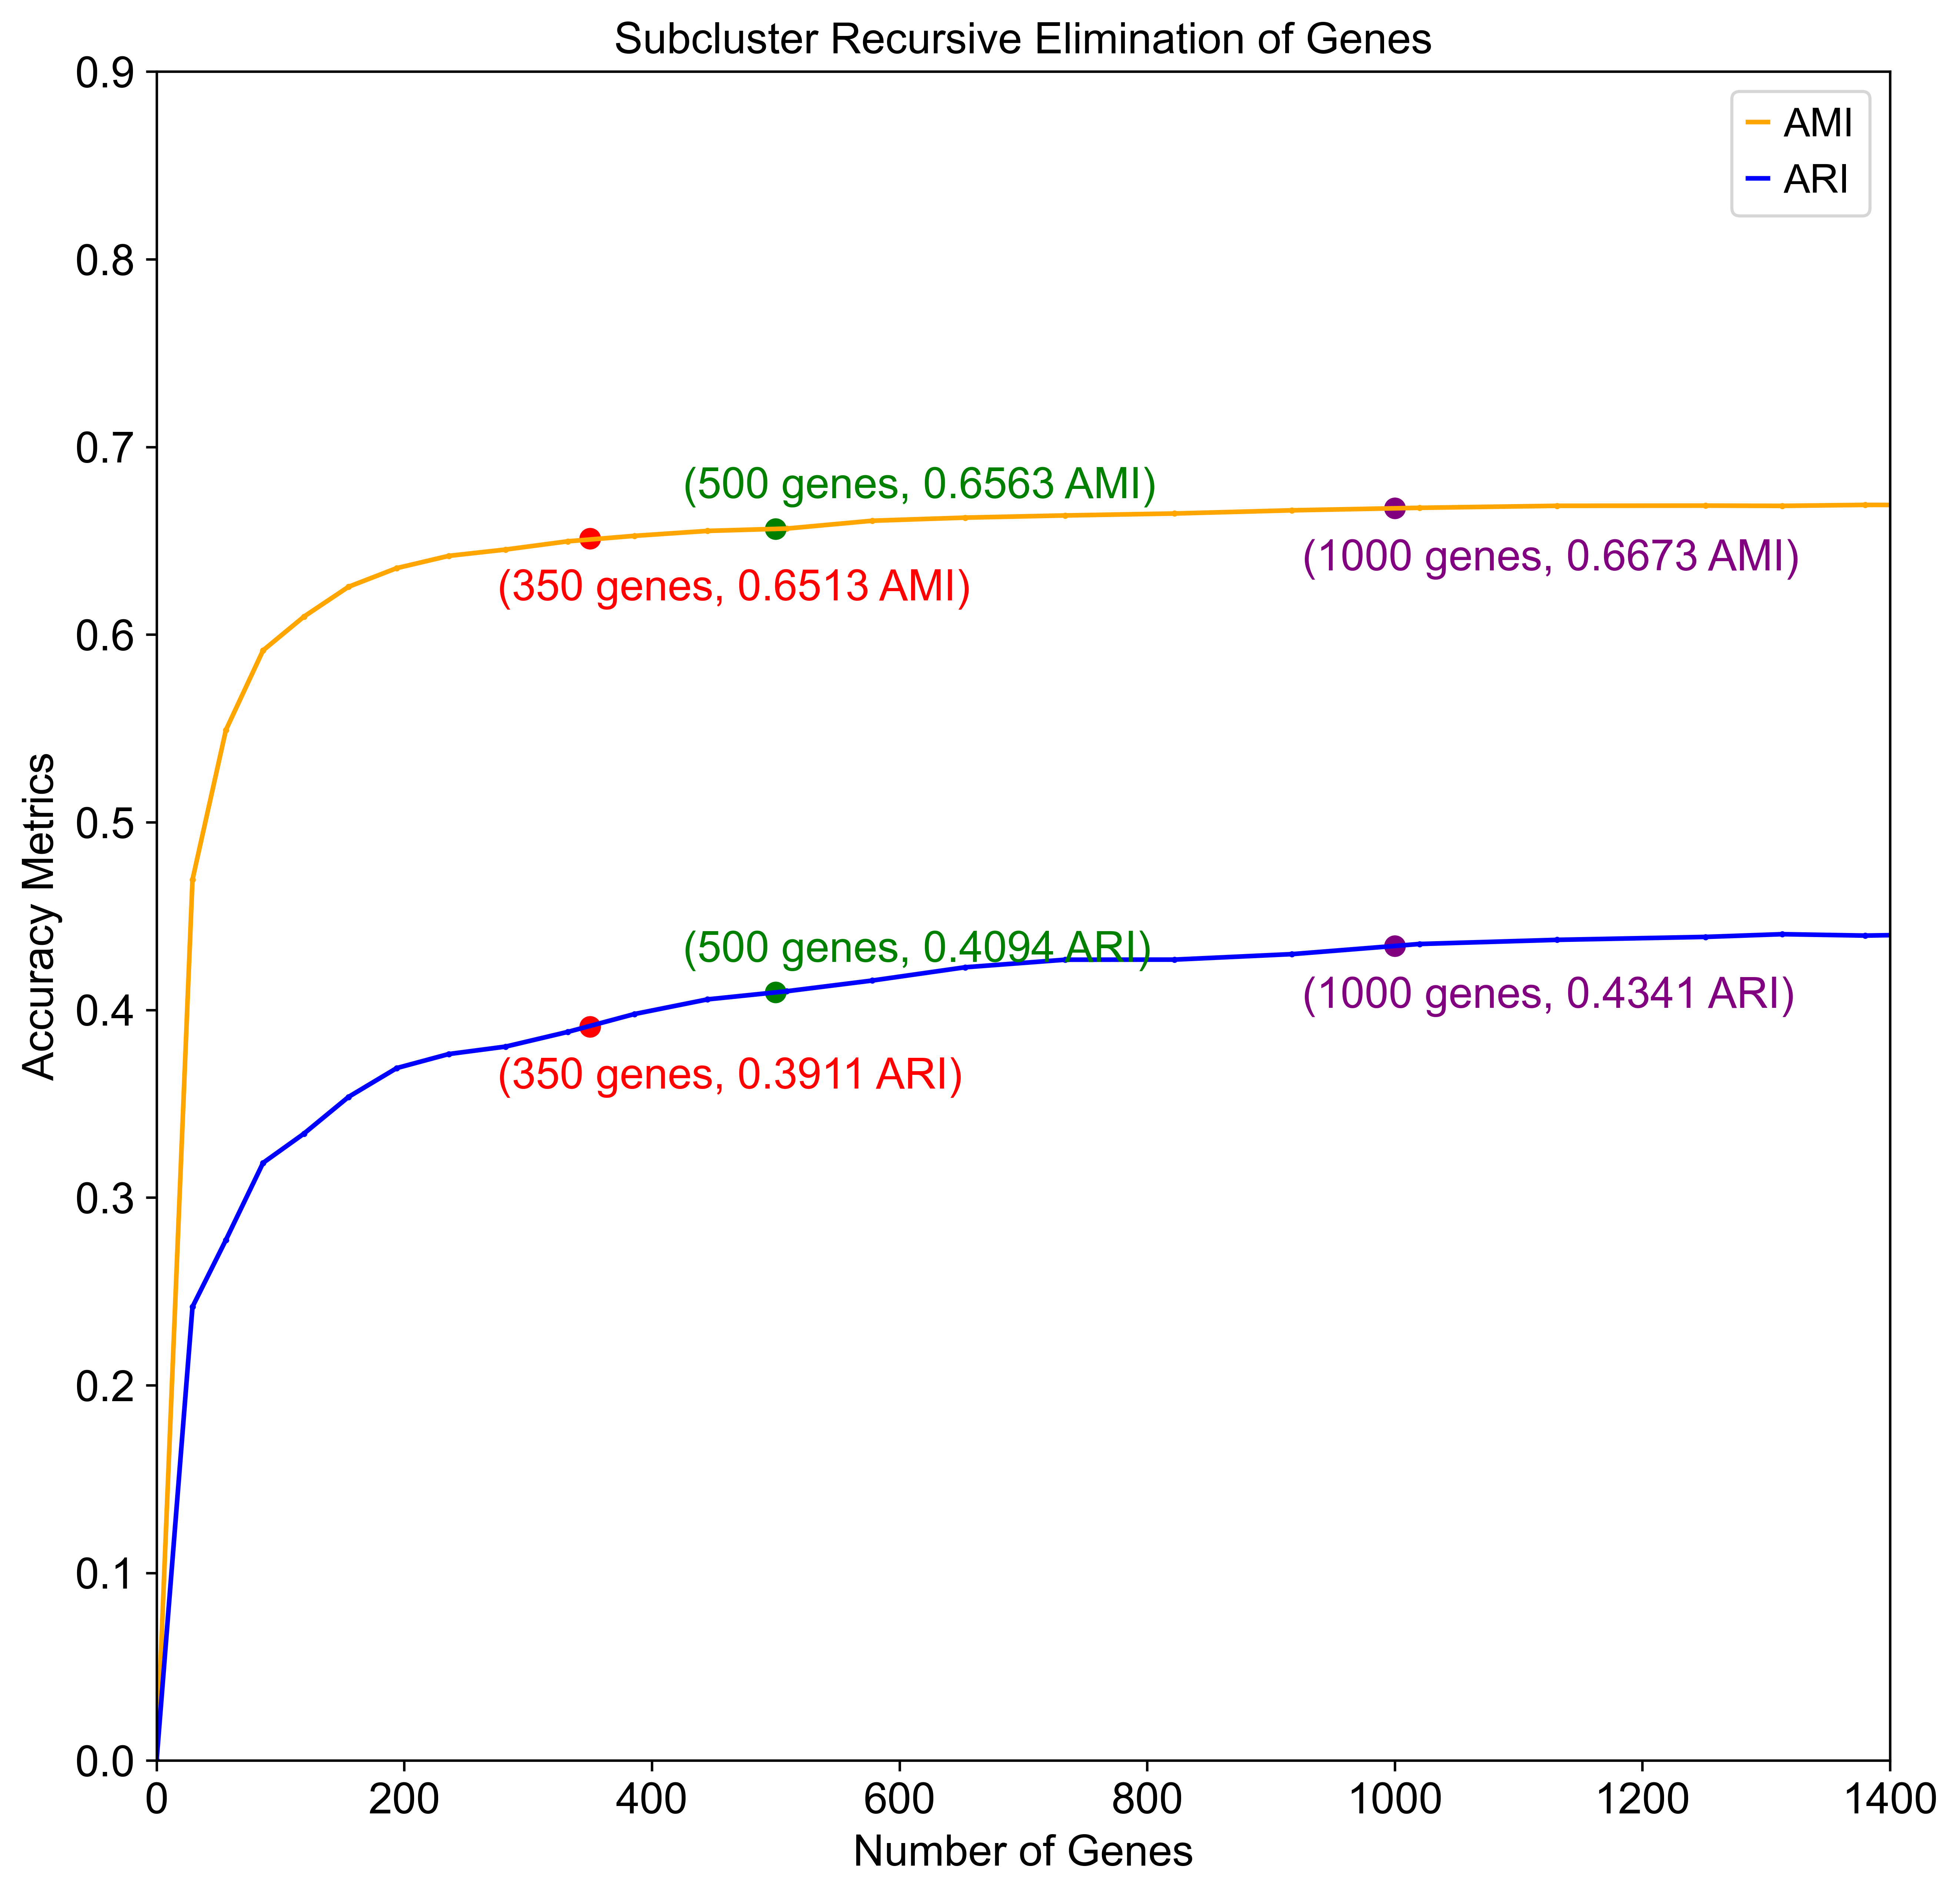

In [ ]:
plt.plot(total_list_sizes[::-1], amis[::-1], label='AMI', color='orange')
plt.scatter(total_list_sizes[::-1], amis[::-1], label=None, color='orange', s=1)
colors = ['red', 'green', 'purple']
# Add red points at specific x-values
red_points = [350, 500, 1000]
cc = 0
for x in red_points:
    # Find the two nearest x-values
    idx = np.abs(np.array(total_list_sizes) - x).argmin()
    x1, x2 = total_list_sizes[idx], total_list_sizes[idx + 1]
    y1, y2 = amis[idx], amis[idx + 1]

    # Calculate the y-value on the line connecting the two nearest data points
    y = y1 + ((x - x1) / (x2 - x1)) * (y2 - y1)

    # Plot the red point
    plt.scatter(x, y, color=colors[cc])

    # Add annotation for the red point
    if x != 500:
        plt.annotate(f"({x} genes, {y:.4f} AMI)", xy=(x, y), xytext=(-30, -20), textcoords="offset points", color=colors[cc])
    else:
        plt.annotate(f"({x} genes, {y:.4f} AMI)", xy=(x, y), xytext=(-30, 10), textcoords="offset points", color=colors[cc])
    cc += 1
plt.plot(total_list_sizes[::-1], aris[::-1], label='ARI', color='blue')
plt.scatter(total_list_sizes[::-1], aris[::-1], label=None, color='blue', s=1)

# Add red points at specific x-values
red_points = [350, 500, 1000]
cc = 0
for x in red_points:
    # Find the two nearest x-values
    idx = np.abs(np.array(total_list_sizes) - x).argmin()
    x1, x2 = total_list_sizes[idx], total_list_sizes[idx + 1]
    y1, y2 = aris[idx], aris[idx + 1]

    # Calculate the y-value on the line connecting the two nearest data points
    y = y1 + ((x - x1) / (x2 - x1)) * (y2 - y1)

    # Plot the red point
    plt.scatter(x, y, color=colors[cc])

    #Add annotation for the red point
    if x != 500:
       plt.annotate(f"({x} genes, {y:.4f} ARI)", xy=(x, y), xytext=(-30, -20), textcoords="offset points", color=colors[cc])
    else:
       plt.annotate(f"({x} genes, {y:.4f} ARI)", xy=(x, y), xytext=(-30, 10), textcoords="offset points", color=colors[cc])
    cc += 1
plt.title('Subcluster Recursive Elimination of Genes')
plt.ylabel('Accuracy Metrics')
plt.xlabel('Number of Genes')
fig = plt.gcf()
fig.dpi = 300
plt.legend()
plt.grid(False)
plt.xlim(0, 1400)
plt.ylim(0, 0.9)
plt.show()